In [1]:
"""
One brick in the hierachy for an industrial ethylene-oxide reactor

© 2023. Triad National Security, LLC. All rights reserved.
This program was produced under U.S. Government contract 89233218CNA000001 for Los Alamos
National Laboratory (LANL), which is operated by Triad National Security, LLC for the U.S.
Department of Energy/National Nuclear Security Administration. All rights in the program are.
reserved by Triad National Security, LLC, and the U.S. Department of Energy/National Nuclear
Security Administration. The Government is granted for itself and others acting on its behalf a
nonexclusive, paid-up, irrevocable worldwide license in this material to reproduce, prepare.
derivative works, distribute copies to the public, perform publicly and display publicly, and to permit.
others to do so.

@author: Sean T. Smith, Oct. 2022
"""

from numpy import array, empty, linspace, sqrt, exp, log
from pandas import DataFrame

%matplotlib inline
import matplotlib.pyplot as plt

# Klugherz & Harriott (1971) study of Ethylene-Oxide Kinetics — Notes & Reproducing Computations
> [Klugherz, Peter D. & Harriott, Peter, "Kinetics of Ethylene Oxidation on a Supported Silver Catalyst," AIChE Journal, Vol. 17, No. 14, July **1971**, pp. 856-866.](references/Klugherz1971-EthyleneOx.pdf)

This study was impressive in its experimental coverage of various pressures of ethylene oxide and oxygen. It is also commendable for the integration of experiment and theory. In the end, the authors provide two reasonable rate laws for ethylene oxide production and one for complete oxidation to carbon dioxide and water. On the other hand, this study was limited to moderately low pressure ($P_{\text{tot.}} = 1.32$ atm), isothermal conditions ($T = 220^{\circ}$ C) and low/constant concentrations of products & inerts ($P_P = 0.01$ atm).

## Experimental setup & details

The experimental setup involves a 28" long 0.5" wide (inner diam. of 0.430") stainless-steel tube reactor containing 10.0g of catalyst and 10g of of inert alumina. Additionally, a thermocouple sheathed in a 1/16" tube was placed within the reactor. The reactor tube was embeded in a temperature-regulating fluidized sand bed. Both the bed and the fluidizing air were electrically heated.  
<img src='figures/Klugherz1971-Fig1.png'>Fig. 1 from Klugherz & Harriott 1971 — Expt. setup.</img>  
The catalyst was prepared manually.  The surface area of the alumina (prior to silver preparation) was reported by the manufacturer as **0.5 m$^2/$g** with a pore volume of $0.15-0.20$ cm$^3/$g. After coating with silver, transmission electron micrographs showed nearly spherical particles of 2000 Angstroms.
Gas feed (ethylene, oxygen & helium) was prepared by flowing through activated charcoal. Flow rates were controlled with precision needle valves and measured with capillary-flow meters. Manometers measured reactor pressure and pressure drop. For analysis, a 0.5cc slug of product (adjusted to STP) was injected into a chromatograph w/ a thermal conductivity detector. It used a 6'x1/8" column packed with 100-120 mesh Porapak Q and was operated at 80C.
30-40 mins. was given to reach steady state for each run.

$$\require{mhchem}$$
\begin{equation} \begin{split}
\ce{C2H4_{(s)} + O_{(s)} &->[Ag][\Delta H = -105 kJ/mol] C2H4O_{(s)}} \\
\ce{C2H4_{(s)} + 6O_{(s)} &->[Ag][\Delta H = -1327 kJ/mol] 2CO2_{(s)} + 2H2O_{(s)}}
\end{split} \end{equation}

Slow variations over time in activity of the catalyst were observed.
For standard conditions, the overall rate of production of ethylene oxide was $6-7 \times 10^{-6} \tfrac{\text{moles of ethylene reacted}}{\text{min } \times \text{ g catalyst}}$. And similarly, the overall rate of production of carbon dioxide was $4-6 \times 10^{-6} \tfrac{\text{moles of ethylene reacted}}{\text{min } \times \text{ g catalyst}}$. The fluctuations motivated an analysis where the rates at various times were normalized by the contemporary rate at the standard conditions. All the experimental results are reported in terms of these relative rates.

I appreciated this approach, because it starts by reporting the a standard rate (providing a zeroth order term), then adds theory for the variations, investigates the resulting behavior of each variation (in a first order approach), and provides a clearly implied uncertainty about the predictive capability of the resulting model.

## Re-implementation of their fitted rate law

In [7]:
# The rate laws:
def R0_C2H4O(Pe, Po):
    """Calculate the relative rate of ethylene-oxide production as suggested by Eq. 32."""
    return Pe * Po**1.5 / (((0.0130 + 0.236 * Pe + 0.121 * sqrt(Po)) * (1 + 0.661 * sqrt(Po)))**2)
def R0_C2H4O_alt(Pe, Po):
    """Calculate the relative rate of ethylene-oxide production as suggested by Eq. 33."""
    return Pe * Po**2 / (((0.0106 + 0.053 * Pe + 0.0199 * Po) * (1 + 6.32 * sqrt(Po)))**2 + 1e-12)
def R0_CO2(Pe, Po):
    """Calculate the relative rate of carbon-dioxide production as suggested by Eq. 34."""
    return Pe * Po**2 / (((0.0080 + 0.103 * Pe + 0.0390 * Po) * (1 + 3.57 * sqrt(Po)))**2)

def rxn_rate(Pe, Po, alt=False):
    """
    Calculate the reaction rates, for the Klugherz model, of ethylene oxide & carbon dioxide
    on a Ag catalyst.
    Inputs:
      Pe - partial pressure of ethylene [atm]
      Po - partial pressure of oxygen [atm]
    Constants:
      T = 220C
      partial pressure of ethylene oxide + carbon dioxide + water = 0.01 atm
    Returns:
      production rate of ethylene oxide [mol / (min g-catalyst)]
      production rate of carbon dioxide [mol / (min g-catalyst)]
    """
    # Production rates of ethylene oxide & carbon dioxide for the standard conditions.
    k_C2H4O = (6 + 7) / 2 * 1e-6 # 8.63  # [moles ethylene / (min * g catalyst)]
    k_CO2 = (4 + 6) / 2 * 1e-6 # 5.67  # [moles ethylene / (min * g catalyst)]
    if not alt:
        R_C2H4O = R0_C2H4O(Pe, Po)  # [-]
    else:
        R_C2H4O = R0_C2H4O_alt(Pe, Po)  # [-]
    R_CO2 = R0_CO2(Pe, Po)  # [-]
    r_C2H4O = k_C2H4O * R_C2H4O  # [moles ethylene / (min * g catalyst)]
    r_CO2 = k_CO2 * R_CO2  # [moles ethylene / (min * g catalyst)]
    return array([r_C2H4O, r_CO2])

In [8]:
print(R0_C2H4O_alt(0.263, 0.263))
print(R0_CO2(0.263, 0.263))

1.1409586969493382
1.1039875999868174


## Reported results & reproduction
Reported experimental rates (with digitation of the plotted values) vs. performance of their fitted rate law...

<img src='figures/Klugherz1971-Fig2.png' width=500>Fig. 2 from Klugherz & Harriott 1971 — behavior in $P_P$.</img>

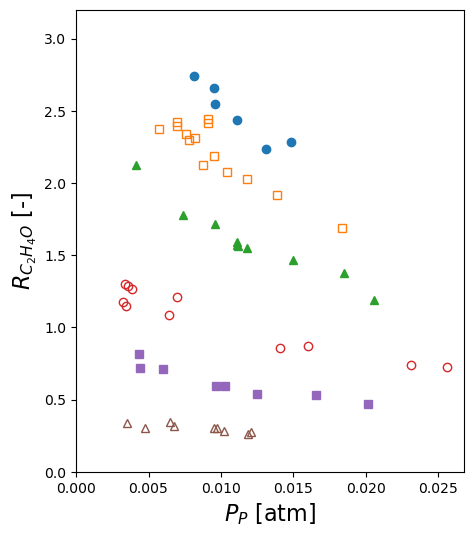

In [9]:
# Variation with product & intert pressure - experimental values:
plt.figure(figsize=(5, 6))
Po = array([1.05, 0.789, 0.526, 0.263, 0.132, 0.061])  # [atm]
Pp = [[0.00353, 0.00476, 0.00650, 0.00675, 0.00953, 0.00972, 0.01021, 0.01188, 0.01207],  # Po = 0.061 atm
      [0.00433, 0.00439, 0.00600, 0.00965, 0.01027, 0.01250, 0.01658, 0.02011],  # Po = 0.132 atm
      [0.00322, 0.00340, 0.00347, 0.00359, 0.00384, 0.00644, 0.00699, 0.01405, 0.01597, 0.02314, 0.025612],  # Po = 0.263 atm
      [0.00415, 0.00736, 0.00959, 0.01108, 0.01108, 0.01114, 0.01182, 0.01498, 0.01850, 0.02054],  # Po = 0.526 atm
      [0.00575, 0.00699, 0.00699, 0.00761, 0.00780, 0.00823, 0.00910, 0.00910, 0.00873, 0.00953, 0.01040, 0.01176, 0.01386, 0.01832],  # Po = 0.789 atm
      [0.00817, 0.00953, 0.00959, 0.01108, 0.01312, 0.01485]]  # Po = 1.05 atm
R  = [[0.33610, 0.30498, 0.34855, 0.31743, 0.30498, 0.30498, 0.28008, 0.26141, 0.2739],  # Po = 0.061 atm
      [0.81535, 0.72199, 0.70954, 0.59129, 0.59129, 0.54149, 0.53527, 0.46680],  # Po = 0.263 atm
      [1.17635, 1.30083, 1.14523, 1.28838, 1.26971, 1.08299, 1.20747, 0.85892, 0.8714, 0.7407, 0.7282],  # Po = 0.263 atm
      [2.12863, 1.78008, 1.71784, 1.59336, 1.56846, 1.56224, 1.54979, 1.46888, 1.3755, 1.1888],  # Po = 0.526 atm
      [2.37759, 2.42116, 2.39627, 2.34025, 2.29668, 2.30913, 2.41494, 2.44606, 2.1224, 2.1909, 2.0788, 2.0290, 1.9170, 1.6867],  # Po = 0.789 atm
      [2.74481, 2.65768, 2.54564, 2.43983, 2.23444, 2.28423]]  # Po = 1.05 atm
marker = ['o', 's', '^', 'o', 's', '^']
face = [None, 'none', None, 'none', None, 'none']
for i in range(Po.shape[0]):
    plt.plot(Pp[i], R[i], marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.xlim(0, None)
plt.ylim(0, 3.2)
plt.xlabel('$P_P$ [atm]', fontsize=16)
plt.ylabel('$R_{C_2H_4O}$ [-]', fontsize=16) ;

<img src='figures/Klugherz1971-Fig3.png' width=300>Fig. 3 from Klugherz & Harriott 1971 — behavior in $P_E$.</img>
<img src='figures/Klugherz1971-Fig4.png' width=300>Fig. 4 from Klugherz & Harriott 1971 — behavior in $P_O$.</img>
<img src='figures/Klugherz1971-Fig5.png' width=300>Fig. 5 from Klugherz & Harriott 1971 — behavior in $P_O$.</img>

Based on the statement in the first paragraph on page 859 about 39 combinations of reactant partial pressures, it was assumed that figures 4 & 5 present the same experimental results as already shown in the figure 3 — but displayed in a way that highlights the reaction behavior in different dimensions. All three are scanned and the redundant data is averaged to reduce any error that results from the plotting in and scanning.  
It is also worth noting that the authors only 'accepted runs in which the partial pressures were within 3% of their desired values' (meaning the recorded values). With few exceptions, the average temperature within the catalyst bed was within 0.5 C of 220 C.

In [10]:
# Rate of ethylene ox. production at various pressures of ethylene & oxygen — experiment:

# As scanned from Fig. 3:
Po = array([ 0.061,  0.132,  0.263,  0.526,  0.789,  1.05,    1.32])  # [atm]
Pe = array([ 0.026,  0.066,  0.132,  0.263,  0.526,  0.789,   1.05,   1.32])  # [atm]
R0 =      [[  None, 0.2318, 0.3146, 0.2980, 0.2252,   None, 0.1192,   None],  # Po = 0.61 atm      
           [  None, 0.3907, 0.5232, 0.5960, 0.5199, 0.4305, 0.3560, 0.2930],  # Po = 0.132 atm
           [0.3195, 0.6076, 0.8162, 1.0050, 0.9652, 0.8725, 0.7202, 0.6970],  # Po = 0.263 atm
           [  None, 0.8990, 1.2070, 1.6209, 1.7997, 1.6672, 1.6076,   None],  # Po = 0.526 atm
           [0.5149, 1.0745, 1.4851, 2.1474, 2.5679, 2.3791,   None,   None],  # Po = 0.789 atm
           [  None, 1.1540, 1.8328, 2.5513, 3.1440,   None,   None,   None],  # Po = 1.05 atm
           [0.5811, 1.2467, 1.9719,   None,   None,   None,   None,   None]]  # Po = 1.32 atm
expt = []
for i in range(Pe.shape[0]):
    for j in range(Po.shape[0]):
        if R0[j][i] is not None:
            expt.append([Pe[i], Po[j], 220 + 273.15, R0[j][i]])#, R1[j][i]])

# As scanned from Fig. 4:
#       Po = 0.061,  0.132,  0.263,  0.526,  0.789,  1.05,    1.32 atm
R0 =      [[  None,   None, 0.3342,   None, 0.5318,   None, 0.5812],  # Pe = 0.026 atm
           [0.2590, 0.4001, 0.6240, 0.9138, 1.0851, 1.1608, 1.2530],  # Pe = 0.066 atm
           [0.3178, 0.5410, 0.8150, 1.2168, 1.4967, 1.8425, 1.9808],  # Pe = 0.132 atm
           [0.2980, 0.6043, 1.0258, 1.6317, 2.1520, 2.5670,   None],  # Pe = 0.263 atm
           [0.2289, 0.5417, 0.9731, 1.8128, 2.5735, 3.1465,   None]]  # Pe = 0.526 atm
for i, Pe_val in enumerate(Pe[:5]):
    for j in range(Po.shape[0]):
        if R0[i][j] is not None:
            expt.append([Pe_val, Po[j], 220 + 273.15, R0[i][j]])#, R1[i][j]])

# As scanned from Fig. 5:
#       Po = 0.061,  0.132,  0.263,  0.526,  0.789,  1.05,    1.32 atm
R0 =      [[0.2384, 0.5364, 0.9801, 1.8113, 2.5695, 3.1457,   None],  # Pe = 0.526 atm
           [  None, 0.4437, 0.8808, 1.6788, 2.3775,   None,   None],  # Pe = 0.789 atm
           [0.1291, 0.3642, 0.7384, 1.6192,   None,   None,   None],  # Pe = 1.05 atm
           [  None, 0.2947, 0.6954,   None,   None,   None,   None]]  # Pe = 1.32 atm
for i, Pe_val in enumerate(Pe[4:8]):
    for j in range(Po.shape[0]):
        if R0[i][j] is not None:
            expt.append([Pe_val, Po[j], 220 + 273.15, R0[i][j]])#, R1[i][j]])

# Combine into a single DataFrame and average over the redundant scans of the same results:
labels = ['Pres. C2H4 [atm]', 'Pres. O2 [atm]', 'Temp. [K]', 'rel. rate C2H4O [-]']
expt_df = DataFrame(expt, columns=labels).groupby(labels[:-1]).mean().reset_index()

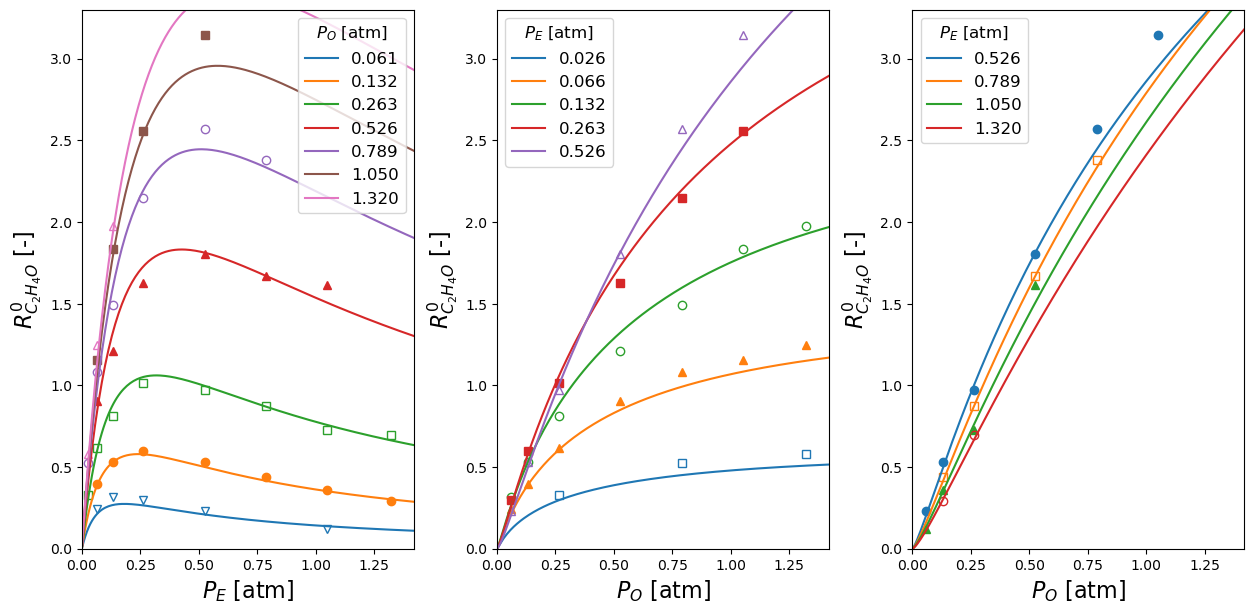

In [11]:
# Rate of ethylene ox. production at various pressures of ethylene & oxygen — experiment vs. theory:
plt.figure(figsize=(15, 7))
plt.subplots_adjust(wspace=0.25)

# Compare to Figs. 3 & 12
plt.subplot(1, 3, 1)
marker = ['v', 'o', 's', '^', 'o', 's', '^']
face = ['none', None, 'none', None, 'none', None, 'none']
for i in range(Po.shape[0]):
    tmp = expt_df.loc[lambda df: df['Pres. O2 [atm]'] == Po[i],
                      ['Pres. C2H4 [atm]', 'rel. rate C2H4O [-]']]
    plt.plot(tmp.iloc[:, 0], tmp.iloc[:, 1],
             marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Pe_m = linspace(0, 1.42, 200)  # atm
R0_m = empty((Po.shape[0], Pe_m.shape[0]))
for i in range(Po.shape[0]):
    R0_m[i] = R0_C2H4O(Pe_m, Po[i])
    plt.plot(Pe_m, R0_m[i], label=f'{Po[i]:.3f}')
plt.xlim(Pe_m[0], Pe_m[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_E$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.legend(title='$P_O$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right') ;

# Compare to Fig. 4
plt.subplot(1, 3, 2) 
marker = ['s', '^', 'o', 's', '^']
face = ['none', None, 'none', None, 'none']
for i, Pe_val in enumerate(Pe[:5]):
    tmp = expt_df.loc[lambda df: df['Pres. C2H4 [atm]'] == Pe_val,
                      ['Pres. O2 [atm]', 'rel. rate C2H4O [-]']]
    plt.plot(tmp.iloc[:, 0], tmp.iloc[:, 1],
             marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Po_m = linspace(0, 1.42, 200)
R0_m = empty((5, Po_m.shape[0]))
for i, Pe_val in enumerate(Pe[:5]):
    R0_m[i] = R0_C2H4O(Pe_val, Po_m)
    plt.plot(Po_m, R0_m[i], label=f'{Pe_val:.3f}')
plt.xlim(Po_m[0], Po_m[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_O$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.legend(title='$P_E$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper left') ;

# Compare to Fig. 5
plt.subplot(1, 3, 3) 
marker = ['o', 's', '^', 'o']
face = [None, 'none', None, 'none']
for i, Pe_val in enumerate(Pe[4:8]):
    tmp = expt_df.loc[lambda df: df['Pres. C2H4 [atm]'] == Pe_val,
                      ['Pres. O2 [atm]', 'rel. rate C2H4O [-]']]
    plt.plot(tmp.iloc[:, 0], tmp.iloc[:, 1],
             marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Po_m = linspace(0, 1.42, 200)  # atm
R0_m = empty((4, Po_m.shape[0]))
for i, Pe_val in enumerate(Pe[4:8]):
    R0_m[i] = R0_C2H4O(Pe_val, Po_m)
    plt.plot(Po_m, R0_m[i], label=f'{Pe_val:.3f}')
plt.xlim(Po_m[0], Po_m[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_O$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.legend(title='$P_E$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper left') ;

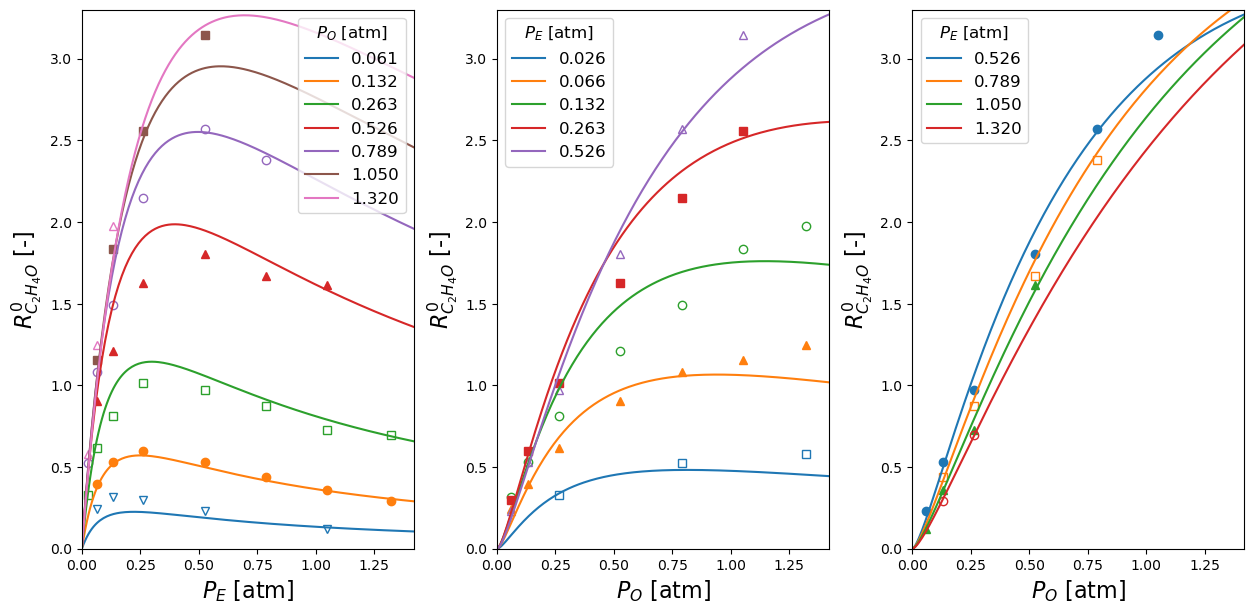

In [12]:
# Rate of ethylene ox. production at various pressures of ethylene & oxygen — experiment vs. theory
# (same as the previous with the authors alternate model):
plt.figure(figsize=(15, 7))
plt.subplots_adjust(wspace=0.25)

# Compare to Figs. 3 & 13
plt.subplot(1, 3, 1)
marker = ['v', 'o', 's', '^', 'o', 's', '^']
face = ['none', None, 'none', None, 'none', None, 'none']
for i in range(Po.shape[0]):
    tmp = expt_df.loc[lambda df: df['Pres. O2 [atm]'] == Po[i],
                      ['Pres. C2H4 [atm]', 'rel. rate C2H4O [-]']]
    plt.plot(tmp.iloc[:, 0], tmp.iloc[:, 1],
             marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Pe_m = linspace(0, 1.42, 200)  # atm
R0_m = empty((Po.shape[0], Pe_m.shape[0]))
for i in range(Po.shape[0]):
    R0_m[i] = R0_C2H4O_alt(Pe_m, Po[i])
    plt.plot(Pe_m, R0_m[i], label=f'{Po[i]:.3f}')
plt.xlim(Pe_m[0], Pe_m[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_E$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.legend(title='$P_O$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right') ;

# Compare to Fig. 4
plt.subplot(1, 3, 2) 
marker = ['s', '^', 'o', 's', '^']
face = ['none', None, 'none', None, 'none']
for i, Pe_val in enumerate(Pe[:5]):
    tmp = expt_df.loc[lambda df: df['Pres. C2H4 [atm]'] == Pe_val,
                      ['Pres. O2 [atm]', 'rel. rate C2H4O [-]']]
    plt.plot(tmp.iloc[:, 0], tmp.iloc[:, 1],
             marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Po_m = linspace(0, 1.42, 200)
R0_m = empty((5, Po_m.shape[0]))
for i, Pe_val in enumerate(Pe[:5]):
    R0_m[i] = R0_C2H4O_alt(Pe_val, Po_m)
    plt.plot(Po_m, R0_m[i], label=f'{Pe_val:.3f}')
plt.xlim(Po_m[0], Po_m[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_O$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.legend(title='$P_E$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper left') ;

# Compare to Fig. 5
plt.subplot(1, 3, 3) 
marker = ['o', 's', '^', 'o']
face = [None, 'none', None, 'none']
for i, Pe_val in enumerate(Pe[4:8]):
    tmp = expt_df.loc[lambda df: df['Pres. C2H4 [atm]'] == Pe_val,
                      ['Pres. O2 [atm]', 'rel. rate C2H4O [-]']]
    plt.plot(tmp.iloc[:, 0], tmp.iloc[:, 1],
             marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Po_m = linspace(0, 1.42, 200)  # atm
R0_m = empty((4, Po_m.shape[0]))
for i, Pe_val in enumerate(Pe[4:8]):
    R0_m[i] = R0_C2H4O_alt(Pe_val, Po_m)
    plt.plot(Po_m, R0_m[i], label=f'{Pe_val:.3f}')
plt.xlim(Po_m[0], Po_m[-1])
plt.ylim(0, 3.3)
plt.xlabel('$P_O$ [atm]', fontsize=16)
plt.ylabel('$R^0_{C_2H_4O}$ [-]', fontsize=16)
plt.legend(title='$P_E$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper left') ;

<img src='figures/Klugherz1971-Fig6.png' width=500>Fig. 6 from Klugherz & Harriott 1971 — behavior in $P_E$.</img>

In [ ]:
#       Pe = 0.026,  0.066,  0.132,  0.263,  0.526,  0.789,   1.05,   1.32 atm
R0 =      [[  None, 0.3551, 0.4041, 0.3061, 0.1959,   None, 0.1163,   None],  # Po = 0.061 atm
           [  None, 0.5571, 0.6429, 0.6000, 0.4041, 0.3000, 0.2388, 0.1837],  # Po = 0.132 atm
           [0.3735, 0.7592, 1.0041, 0.9980, 0.7531, 0.6367, 0.4776, 0.4469],  # Po = 0.263 atm
           [  None, 0.9612, 1.3224, 1.6286, 1.4571, 1.2000, 1.0592,   None],  # Po = 0.526 atm
           [0.4776, 1.0469, 1.5490, 2.0816, 2.1612, 1.7633,   None,   None],  # Po = 0.789 atm
           [  None, 1.1633, 1.8000, 2.4000, 2.6265,   None,   None,   None],  # Po = 1.05 atm
           [0.5082, 1.1327, 2.0755,   None,   None,   None,   None,   None]]  # Po = 1.32 atm
expt = []
for i in range(Pe.shape[0]):
    for j in range(Po.shape[0]):
        if R0[j][i] is not None:
            expt.append([Pe[i], Po[j], 220 + 273.15, R0[j][i]])
labels = ['Pres. C2H4 [atm]', 'Pres. O2 [atm]', 'Temp. [K]', 'rel. rate CO2 [-]']
expt_df = DataFrame(expt, columns=labels).groupby(labels[:-1]).mean().reset_index()

In [ ]:
# Rate of production of carbon dioxide at various pressures of ethylene & oxygen — experiment & theory:
plt.figure(figsize=(15, 7))
plt.subplots_adjust(wspace=0.25)

# Compare to Figs: 6 & 14
plt.subplot(1, 3, 1)
marker = ['v', 'o', 's', '^', 'o', 's', '^']
face = ['none', None, 'none', None, 'none', None, 'none']
for i in range(Po.shape[0]):
    tmp = expt_df.loc[lambda df: df['Pres. O2 [atm]'] == Po[i],
                      ['Pres. C2H4 [atm]', 'rel. rate CO2 [-]']]
    plt.plot(tmp.iloc[:, 0], tmp.iloc[:, 1],
             marker=marker[i], markerfacecolor=face[i], linestyle='none')
plt.gca().set_prop_cycle(None)
Pe_m = linspace(0, 1.42, 200)  # atm
R0_m = empty((Po.shape[0], Pe_m.shape[0]))
for i in range(Po.shape[0]):
    R0_m[i] = R0_CO2(Pe_m, Po[i])
    plt.plot(Pe_m, R0_m[i], label=f'{Po[i]:.3f}')
plt.xlim(Pe_m[0], Pe_m[-1])
plt.ylim(0, 3.1)
plt.xlabel('$P_E$ [atm]', fontsize=16)
plt.ylabel('$R^0_{CO_2}$ [-]', fontsize=16)
plt.legend(title='$P_O$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right')

plt.subplot(1, 3, 2) 
Po_m = linspace(0, 1.42, 200)  # atm
R0_m = empty((5, Po_m.shape[0]))
for i, Pe_val in enumerate(Pe[:5]):
    R0_m[i] = R0_CO2(Pe_val, Po_m)
    plt.plot(Po_m, R0_m[i], label=f'{Pe_val:.3f}')
plt.xlim(Po_m[0], Po_m[-1])
plt.ylim(0, 3.1)
plt.xlabel('$P_O$ [atm]', fontsize=16)
plt.ylabel('$R^0_{CO_2}$ [-]', fontsize=16)
plt.legend(title='$P_E$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right')

plt.subplot(1, 3, 3) 
Po_m = linspace(0, 1.42, 200)  # atm
R0_m = empty((4, Po_m.shape[0]))
for i, Pe_val in enumerate(Pe[4:8]):
    R0_m[i] = R0_CO2(Pe_val, Po_m)
    plt.plot(Po_m, R0_m[i], label=f'{Pe_val:.3f}')
plt.xlim(Po_m[0], Po_m[-1])
plt.ylim(0, 3.1)
plt.xlabel('$P_O$ [atm]', fontsize=16)
plt.ylabel('$R^0_{CO_2}$ [-]', fontsize=16)
plt.legend(title='$P_E$ [atm]', title_fontsize=12,
           fontsize=12, loc='upper right') ;

## Store the experimental data into a single data frame

In [ ]:
col_labels = ['Pres. C2H4 [atm]', 'Pres. O2 [atm]', 'Temp. [K]', 'rel. rate C2H4O [-]', 'rel. rate CO2 [-]']
expt_df = DataFrame(expt, columns=col_labels)
expt_df

# Al-Saleh, Al-Ahmadi, Shalabi (1988) Ethylene-Oxide Kinetics with Activation Energy
> [M.A. Al-Saleh, M.S. Al-Ahmadi, M.A. Shalabi, "Kinetic Study of Ethylene Oxidation in a Berty Reactor," Chem. Eng. J., Vol. 37, **1988**, pp. 35-41.](references/AlSaleh1987-EthyleneOx.pdf)

Initially I was optimistic that this paper would augment the information in [Klugherz 1971] by providing the necessary temperature data to determine the Arrhenius rate parameters.

In [ ]:
# Reported in the context of feed compositions to a "perfectly mixed CSTR" (not product compositions)
# 3-6% ethylene & 18-19.5% oxygen (balance being nitrogen) at P=2170 kN/m^2
# Table 2:
Temp = array([  553,   553,   553,   533,   533,   533,   533,   513,   513,   513,   513])  # [K]
Reo  = array([3.146, 5.093, 9.336, 0.602, 2.661, 4.590, 8.032, 0.644, 1.980, 3.262, 3.664]) * 1e-4  # [mol / (g-cat. hr)]
Rco2 = array([2.229, 2.676, 3.564, 0.692, 1.379, 1.582, 2.215, 0.505, 0.763, 0.902, 0.989]) * 1e-4  # [mol / (g-cat. hr)]
# It seems clear that the composition was varied (increasing reactants) at each temperature, but those values were not specified.

# Borman & Westerterp (1995) and Schouten, Borman & Westerterp (1996) two studies on Ethylene-Oxide Kinetics — Notes & Reproducing Computations
> [Borman, Peter C. & Westerterp, K. Roel, "An Experimental Study of the Kinetics of the Selective Oxidation of Ethene over Silver on α-Alumina Catalyst," Ind. Eng. Chem. Res., Vol. 34, **1995**, pp. 49-58.](references/Borman1995-EthyleneOxideKinetics.pdf)

> [Schouten, E.P.S., Borman, P.C. & Westerterp, K.R., "Influence of reaction products on the selective oxidation of ethene," Chem. Eng. & Processing, Vol. 35, **1996**, pp. 107-120.](references/Schoutten1996-BormanFollowUp.pdf)

These manuscripts seems insightful in that they provide a thorough summary of the literature that preceded while thoughtfully addressing the miriad of complicating factors associated with the phenomena of ethylene's heterogeneous reactions on silver. I was also given the impression that much of their summary has been informed by logical deduction and quantitative analysis. Equally important, it seems they purposefully omitted extraneous details.  
Given that high praise, I was greatly disappointed by three issues in these manuscripts (common to both). The first issue is that they are critical of the literature which proceeded them on the issue of neglecting to report experimental results (stating that they found themselves in the unfortunate situation of needing to reproduce the experiments themselves), however they provide fewer experimental results than almost any of those proceeding papers (neither in graphical nor tabular form). The second issue is more of a concern, because I am not entirely sure — but they seem to indicate (with two separate comments in each paper) that in the rate expressions applied to their well-stirred reactor they used inlet-stream concentrations rather than measured concentrations at the outlet. The third and most critical issue is that I have found the reported empirically fit models to be entirely irreproducible. All three models found in Table 5 of the first paper, using the parameters listed in Table 6, displayed orders of magnitude difference in the ratio of rates between ethylene oxide and carbon dioxide. This was grossly inconsistent with their own Fig. 6 as well as the baseline conditions & rates from Klugherz 1971 (which I resorted to for comparison given there were no quantitative results to compare against in that paper). In their second paper, Table 5 provided quantitative reference values for the theoretical models (still no experimental values for reaction rates). However, I was still unable to find any combination of parameters from Table 3, in that paper, used in any of the models in Eq. 1 that would reproduce the corresponding reference values in Table 5 — and again some ratios of rates between ethylene oxide and carbon dioxide were orders of magnitude different.

## Reported results & (lack of) reproduction
Performance of their fitted rate law compared to reference model values...

In [ ]:
def rxn_rate(Pi, T, a=1):
    """
    Calculate the reaction rates, for the Borman & Westerterp 1995 rate — model I,
    of ethylene oxide & carbon dioxide on a Ag catalyst.
    """
    Pe, Po, Peo, Pc, Pw = Pi
    A = array([2.9e3, 1.42e6])  # pre-exp of the rate coefficients [mol/(kg s)]
    Ta = array([8070, 11380])  # activation temps. of the rate coeffs. [K]
    Ke = array([30.0, 49.4])  # equilib. consts., K, for C2H4 adsorption [1/bar]
    Kc = array([87.4, 114.4])  # equilib. consts., K, for CO2 [1/bar]
    Keo = array([90.0, 48.8])  # equilib. consts., K, for C2H4O adsorption [1/bar]
    Aw = array([0.368, 4.04e-2])  # pre-exp of K for H2O adsorption [1/bar]
    Taw = array([2370, 3430])  # activation temps. of K for H2O adsorption [K]
    n = array([0.127, 0.140])  # order of oxygen in each reaction expression [-]
    
    k = A * exp(-Ta / T)
    print(k, A, Ta, T)
    print(array([8.7e4, 7.02e7]) * exp(-array([8070, 11380]) / T))
    Kw = Aw * exp(Taw / T)
    
    F = 1 + Ke * Pe + Kc * Pc + Kw * Pw + Keo * Peo
    r = empty(3)
    r[:2] =  (k / a) * Ke * Pe * Po**n / F
    r[2] = 1.7e5 * exp(-10500/T) * Peo**0.4
    return r
# Pi = 5 * (array([1.8, 21 * (1 - 1.8/100), 0, 0, 0]) / 100)  # inlet partial pressures [bar]
# test = rxn_rate(Pi, 500)
# print(test * 1e6)
Pi = 1.013 * array([0.263, 0.263, 0, 0, 0]) # inlet partial pressures [bar]
test = rxn_rate(Pi, 220 + 273.15)
print(test * 60 / 1000)

In [ ]:
def rxn_rate(Pi, T, a=1):
    """
    Calculate the reaction rates, for the Borman & Westerterp 1995 rate — model II,
    of ethylene oxide & carbon dioxide on a Ag catalyst.
    """
    Pe, Po, Peo, Pc, Pw = Pi
    
    # # Parameters from their 1995 paper
    # A = array([4.72e12, 1.08e8])  # pre-exp of the rate coefficients [mol/(kg s)]
    # Ta = array([17070, 14650])  # activation temps. of the rate coeffs. [K]
    # Ae = array([2.05e-7, 4.0e-3])  # pre-exp of K for C2H4 adsorption [1/bar]
    # Tae = array([8550, 4180])  # activation temps. of K for C2H4 adsorption [K]
    # Kc = array([83.9, 98.5])  # equilib. consts., K, for CO2 [1/bar]
    # Aeo = array([91.8, 1.21])  # pre-exp of K for C2H4O adsorption [1/bar]
    # Taeo = array([0, 1680])  # activation temps. of K for C2H4O adsorption [K]
    # Aw = array([8.25, 0.109])  # pre-exp of K for H2O adsorption [1/bar]
    # Taw = array([840, 2910])  # activation temps. of K for H2O adsorption [K]
    # Ko = array([84.8, 66.7])  # equilib. consts., K, for O2 [1/bar]
    # k = A * exp(-Ta / T)
    # print(k, A, Ta, T)
    # print(array([9.1e6, 3.77e8]) * exp(-array([8550, 10470]) / T))
    # Ke = Ae * exp(Tae / T)
    # Keo = Aeo * exp(Taeo / T)
    # Kw = Aw * exp(Taw / T)

    # Parameters from their 1996 paper
    A = array([36.5e6, 0.316e9])  # pre-exp of the rate coefficients [mol/(kg s)]
    Ta = array([8.8e3, 12.8e3])  # activation temps. of the rate coeffs. [K]
    Ae = array([0.022, 0.0065])  # pre-exp of K for C2H4 adsorption [1/bar]
    Tae = array([3.0e3, 3.6e3])  # activation temps. of K for C2H4 adsorption [K]
    Ko = array([1.5, 3.0])  # equilib. consts., K, for O2 [1/bar]
    Keo = array([0.10e3, 0.25e3])  # equilib. consts., K, for C2H4O adsorption [1/bar]
    Kc = array([60, 0.13e3])  # equilib. consts., K, for CO2 [1/bar]
    Kw = array([40, 55])  # equilib. consts., K, for H2O adsorption [1/bar]
    k = A * exp(-Ta / T)
    Ke = Ae * exp(Tae / T)


    F = 1 + Ke * Pe + Ko * Po + Kc * Pc + Kw * Pw + Keo * Peo
    r = empty(3)
    r[:2] =  (k / a) * Ke * Pe * Ko * Po / F**2
    r[2] = 1.7e5 * exp(-10500/T) * Peo**0.4
    return r
# # 1995 Paper, Standard Conditions
# Pi = 5 * (array([1.8, 21 * (1 - 1.8/100), 0, 0, 0]) / 100)  # inlet partial pressures [bar]
# test = rxn_rate(Pi, 500)
# print(test * 1e6)
# 1996 Paper, Case A
Pi = array([35.8e-3, 1.05, 0, 0, 0])  # inlet partial pressures [bar]
print(rxn_rate(Pi, 465.5))
# 1996 Paper, Case B
Pi = array([30.3e-3, 1.03, 3.3e-3, 4.6e-3, 4.6e-3])  # inlet partial pressures [bar]
print(rxn_rate(Pi, 501.0))
# 1996 Paper, Case C
Pi = array([23.2e-3, 1.01, 6.5e-3, 12.5e-3, 12.5e-3])  # inlet partial pressures [bar]
print(rxn_rate(Pi, 476.2))
# Klugherz, Standar Conditions
# Pi = 1.013 * array([0.263, 0.263, 0, 0, 0]) # inlet partial pressures [bar]
# test = rxn_rate(Pi, 220 + 273.15)
# print(test * 60 / 1000)

In [ ]:
def rxn_rate(Pi, T, a=1):
    """
    Calculate the reaction rates, for the Borman & Westerterp 1995 rate — model III,
    of ethylene oxide & carbon dioxide on a Ag catalyst.
    """
    Pe, Po, Peo, Pc, Pw = Pi
    
#     # Parameters from their 1995 paper
#     A = array([3.43e13, 8.1e9])  # pre-exp of the rate coefficients [mol/(kg s)]
#     Ta = array([18070, 14250])  # activation temps. of the rate coeffs. [K]
#     Ae = array([2.67e-8, 5.30e-3])  # pre-exp of K for C2H4 adsorption [1/bar]
#     Tae = array([9520, 3780])  # activation temps. of K for C2H4 adsorption [K]
#     Kc = array([83.9, 107])  # equilib. consts., K, for CO2 [1/bar]
#     Aeo = array([91.8, 1.49])  # pre-exp of K for C2H4O adsorption [1/bar]
#     Taeo = array([0, 1570])  # activation temps. of K for C2H4O adsorption [K]
#     Aw = array([1.99, 7.45e-3])  # pre-exp of K for H2O adsorption [1/bar]
#     Taw = array([1510, 4130])  # activation temps. of K for H2O adsorption [K]
#     Ko = array([9.97, 8.76])  # equilib. consts., K, for O2 [1/bar]
#     k = A * exp(-Ta / T)
#     print(k, A, Ta, T)
#     print(array([8.9e6, 3.53e6]) * exp(-array([8520, 10470]) / T))
#     Ke = Ae * exp(Tae / T)
#     Keo = Aeo * exp(Taeo / T)
#     Kw = Aw * exp(Taw / T)

    # Parameters from their 1996 paper
    A = array([0.695e6, 0.15e9])  # pre-exp of the rate coefficients [mol/(kg s)]
    Ta = array([9.0e3, 11.4e3])  # activation temps. of the rate coeffs. [K]
    Ae = array([0.012, 0.14])  # pre-exp of K for C2H4 adsorption [1/bar]
    Tae = array([3.1e3, 2.3e3])  # activation temps. of K for C2H4 adsorption [K]
    Ko = array([8.8, 14.9])  # equilib. consts., K, for O2 [1/bar]
    Keo = array([88, 0.38e3])  # equilib. consts., K, for C2H4O adsorption [1/bar]
    Kc = array([75, 0.13e3])  # equilib. consts., K, for CO2 [1/bar]
    Kw = array([63, 28])  # equilib. consts., K, for H2O adsorption [1/bar]
    k = A * exp(-Ta / T)
    Ke = Ae * exp(Tae / T)

    # Model Calculation
    F = 1 + Ke * Pe + sqrt(Ko * Po) + Kc * Pc + Kw * Pw + Keo * Peo
    r = empty(3)
    r[:2] =  (k / a) * Ke * Pe * sqrt(Ko * Po) / F**2
    r[2] = 1.7e5 * exp(-10500/T) * Peo**0.4
    return r
# 1995 Paper, Standard Conditions
# Pi = 5 * (array([1.8, 21 * (1 - 1.8/100), 0, 0, 0]) / 100)  # inlet partial pressures [bar]
# test = rxn_rate(Pi, 500)
# print(test * 1e6)
# 1996 Paper, Case A
Pi = array([35.8e-3, 1.05, 0, 0, 0])  # inlet partial pressures [bar]
print(rxn_rate(Pi, 465.5))
# 1996 Paper, Case B
Pi = array([30.3e-3, 1.03, 3.3e-3, 4.6e-3, 4.6e-3])  # inlet partial pressures [bar]
print(rxn_rate(Pi, 501.0))
# 1996 Paper, Case C
Pi = array([23.2e-3, 1.01, 6.5e-3, 12.5e-3, 12.5e-3])  # inlet partial pressures [bar]
print(rxn_rate(Pi, 476.2))
# Klugherz, Standar Conditions
# Pi = 1.013 * array([0.263, 0.263, 0, 0, 0]) # inlet partial pressures [bar]
# test = rxn_rate(Pi, 220 + 273.15)
# print(test * 60 / 1000)

# Pu, Tian, Ford, Rangarajan & Wachs (2019) Literature Review of Ethylene-Oxide Kinetics — Notes
> [Tiancheng Pu, Huijie Tian, Micheal E. Ford, Srinivas Rangarajan, and Isreal Wachs, "Overview of Selective Oxidation of Ethylene to Ethylene Oxide by Ag Catalysts," ACS Catal., Vol. 9, **2019**, pp. 10727-10750.](references/Pu2019-EthyleneOxReview.pdf)

This is a high-level review. While lacking quantitative calculations of its own, it addresses everything from the frequency of publication on ethylene-oxide, the various catalyst chemistries, the various proposed macroscopic mechanisms (with variety of rate parameters), all the way to the recent studies based on density-functional theory and the associated micro-kinetic modeling. Ultimately, it does not provide any definitive answers. It does provide reference for where to find more details.

# van den Reijen, Versluis, Kanungo, d'Angelo, de Jong, de Jongh (2019) Catalyst effect on isomerization of Ethylene-Oxide to Acetaldehyde
> [J.E. van den Reijen, W.C. Versluis, S. Kanungo, M.F. d'Angelo, K.P. de Jong, P.E. de Jongh, "From qualitative to quantitative understanding of support effects on the selectivity in silver catalyzed ethylene epoxidation," Catalysis Today, Vol. 338, **2019**, pp. 31-39.](references/vandenReijen2019-Isomerization2acetaldehyde.pdf)

This paper discusses higher-order effects of the catalyst support and even additives to the silver & support. The focus is on secondary reactions — prominently the isomerization of ethylene-oxide to acetaldehyde by acidic sites of a support followed by rapid oxidation to carbon dioxide and water. They address the previous literature having shown increasing selectivity corresponding to decreasing support acidity: $\alpha$-alumina (having the lowest acidity and highest selectivity), then silica, with titania & $\gamma$-alumina showing lower selectivity. This is also consistent with the observation that selectivity will decrease for catalyst surface areas above a certain threshold — the silver tends to aggregate into surface beads and additional area only increases the support sites. Cesium is often added to the catalyst to passivate the acidic surface groups. The impregnation occurs at the same time as the silver, so it is incorporated into the silver itself which results is a lower quality silver surface. A little cesium will generally improve selectivity, but large amounts should be avoided.  
The authors go into the miriad of details for the experimental setup. From a big picture, they were able to use similar loading of silver with similarly sized beads on a variety of different catalyst supports.  
<span>
    <a href="./references/vandenReijen2019-Isomerization2acetaldehyde.pdf" /> <img src="./figures/vandenReijen2019-Fig2a.png" width="230px"/> </a>
    <a href="./references/vandenReijen2019-Isomerization2acetaldehyde.pdf" /> <img src="./figures/vandenReijen2019-Fig2b.png" width="230px"/> </a>
    Fig. 2 (left & middle frames) from van den Reijen 2019.
</span>  
Figure 2 was enlightening to me — I had not realized how small the silver coverage is. It seems this is a modern approach to avoid the sintering/aggregation of the silver bead which deactivates the catalyst. The different supports they produced were summarized in Table 1. They range in surface area from $<1$ to $>300$ m$^2$/g. The materials were $\ce{Al2O3}$, $\ce{SiO2}$. The surface of the silica also had to variations: standard & silylated. *(I had to [look this up](https://en.wikipedia.org/wiki/Silylation): it means coated with $\ce{SiMe3}$ where the $\ce{Me}$ is usually a methyl group.)* They were able to show that their different materials, given the same temperature and presumably same feed composition, would result in the same conversion (Fig. 3).  
<span>
    <a href="./references/vandenReijen2019-Isomerization2acetaldehyde.pdf" /> <img src="./figures/vandenReijen2019-Fig3a.png" width="230px"/> </a>
    <a href="./references/vandenReijen2019-Isomerization2acetaldehyde.pdf" /> <img src="./figures/vandenReijen2019-Fig3b.png" width="235px"/> </a>
    <a href="./references/vandenReijen2019-Isomerization2acetaldehyde.pdf" /> <img src="./figures/vandenReijen2019-Fig3c.png" width="255px"/> </a>
    Fig. 3 (left, middle & right frames) from van den Reijen 2019.
</span>  
This result is unique to this study due to their ability to control the silver loading and size. Yet, with the same conversion different supports & surfaces would result in different selectivity. They argue convincingly, but not definitively, that this shows the primary reactions of ethylene (to both ethylene oxide and $\ce{CO2}$/water) occur on the silver while the secondary oxidation (of ethylene oxide to $\ce{CO2}$/water) occurs on the support. The experimental results also strongly demonstrate the trend of lower conversion with higher support surface area (Fig. 4).  
<a href="./references/vandenReijen2019-Isomerization2acetaldehyde.pdf" /> <img src="./figures/vandenReijen2019-Fig4.png" width=350px> </img> Fig. 4 from van den Reijen 2019.</a>  
And that the resulting rate is linear in surface area (Fig. 5).  
<a href="./references/vandenReijen2019-Isomerization2acetaldehyde.pdf" /> <img src="./figures/vandenReijen2019-Fig5.png" width=350px> </img> Fig. 4 from van den Reijen 2019.</a>  
They show that $\ce{Al2O3}$ provides higher selectivity than untreated $\ce{SiO2}$ (agreeing with the hypothesis) and suggesting the reaction rate for the secondary oxidation is lower for the former. Providing much stronger evidence for their hypothesis, they were able to show that the treated $\ce{SiO2}$ surface provided significantly better yield (implying lower reaction rate) — even than the $\ce{Al2O3}$. They also investigated the temperatures at which the coating destablized, but were not concrete about the result.

In [ ]:
# Figure 3b, blue points
T = array([190.0, 200.0, 210.0, 230.0, 250.0, 270.0]) + 273.15
S = array([73.05, 68.07, 62.46, 54.21, 48.44, 41.90]) / 100

# Back-of the envelope analysis for activation temperature:
Ea1 = 67  # [kJ / mol]
Ta1 = Ea1 * 1e3 / 8.31446
print(Ta1)
ΔTa = log((1/S[0] - 1) / (1/S[-1] - 1)) / (1 / T[0] - 1 / T[-1])
print(ΔTa)
Ta2 = Ta1 - ΔTa
print(Ta2)

# ...for pre-exponentials:
Tref = 220 + 273.15  # reference temperature [K]
k_ref = 1.3  # reference rate coefficient
Ta = Ta1  # activation temperature
A = k_ref * exp(Ta / Tref)
print(A)

In [ ]:
# Figure 5
a_SiO2 = [ 1.9, 51.1, 201.3, 279.9, 316.3]  # support specific surface area [m^2 / g]
R_SiO2 = [29.0, 74.4, 250.7, 381.7, 450.1]  # ratio of rate coefficient, k3 / k1 [atm^{1/2}]
m_SiO2_author = 435.3 / 316.3  # slope of authors' fit
print(m_SiO2_author)
a_Al2O3 = [1.3, 8.9, 21.7]  # support specific surface area [m^2 / g]
R_Al2O3 = [5.2, 7.4, 14.9]  # ratio of rate coefficient, k3 / k1 [-]
m_Al2O3_author = 95.2 / 121.4  # slope of authors' fit
print(m_Al2O3_author)